* import power spectrum
* create map
* create derivative maps

In [1]:
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from IPython.display import Image
%matplotlib inline
plt.rcParams['figure.figsize'] = [8,6]
plt.rcParams['font.size'] = 15

In [2]:
files = ['/global/u2/i/iameric/class/output/test_cl_lensed.dat']
data = []
for data_file in files:
    data = np.loadtxt(data_file)
#1:l     2:TT      3:EE       4:TE      5:BB   6:phiphi       7:TPhi      8:Ephi
names = ['l','TT','EE','BB','TE','phiphi','Tphi','Ephi']

# l starts with 2 in class's output ps
# let Cl=0 when l = 1
def remove_norm(Cl):
    return np.array([2*np.pi*1/l/(l+1)*Cl[l-1] for l in range(1,1+len(Cl))])
l = data[:,0]
TT = remove_norm(np.insert(data[:,1],0,0))
EE = remove_norm(np.insert(data[:,2],0,0))
BB = remove_norm(np.insert(data[:,3],0,0))
TE = remove_norm(np.insert(data[:,4],0,0))

In [4]:
nside = 1024
# map output is an tuple of three maps: T, Q, U
# alm output is an tuple of alm's of the T, Q, U maps
testmap, testalm = hp.synfast((TT,EE,BB,TE), nside = nside, new = True, alm = True, fwhm = 0.012)
# dermap[0] is the original map, dermap[1], [2] are derivative with respect to theta and phi. (d_phi is devided with sin(theta))
maps, d_theta, d_phi = hp.alm2map_der1(testalm[0], nside = nside)

# create a map of sin(theta), to get rid of the sin(theta) in the d_phi map.
#With this, we can create maps of the second derivative
sin_theta = np.sin(hp.pix2ang(nside = nside, ipix = range(hp.nside2npix(nside)))[0])
cos_theta = np.cos(hp.pix2ang(nside = nside, ipix = range(hp.nside2npix(nside)))[0])
d_phi = d_phi*sin_theta

#create second derivative maps
maps, dermap_tt, dermap_tp = hp.alm2map_der1(hp.map2alm(d_theta),nside = nside)
dermap_tp = dermap_tp*sin_theta
dermap_pp = hp.alm2map_der1(hp.map2alm(d_phi), nside = nside)[2]
dermap_pp = dermap_pp*sin_theta

Sigma is 17.518520 arcmin (0.005096 rad) 
-> fwhm is 41.252961 arcmin


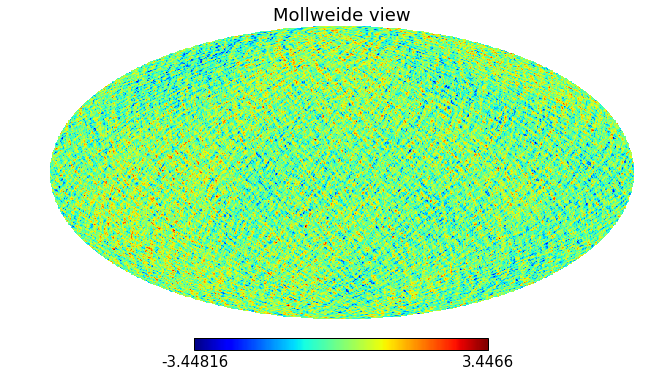

In [7]:
hp.mollview(testmap[2])

In [9]:
# save fit files
hp.write_map('../maps/T_sim.fits',testmap[0], fits_IDL=False)
hp.write_map('../maps/d_p_sim.fits',d_phi, fits_IDL=False)
hp.write_map('../maps/d_t_sim.fits',d_theta, fits_IDL=False)
hp.write_map('../maps/d_tt_sim.fits',dermap_tt, fits_IDL=False)
hp.write_map('../maps/d_tp_sim.fits',dermap_tp, fits_IDL=False)
hp.write_map('../maps/d_pp_sim.fits',dermap_pp, fits_IDL=False)
hp.write_map('../maps/Q_sim.fits', testmap[1], fits_IDL=False)
hp.write_map('../maps/U_sim.fits', testmap[2], fits_IDL=False)

## first derivatives

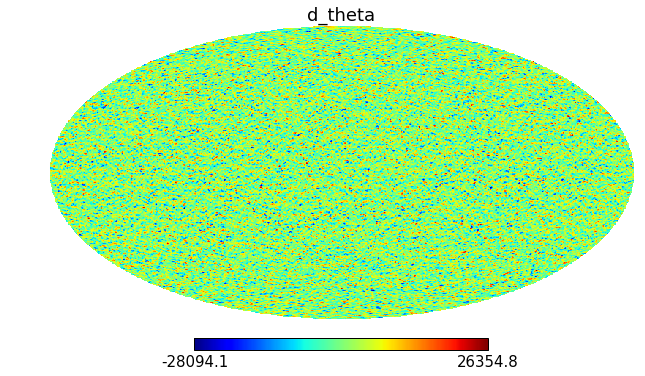

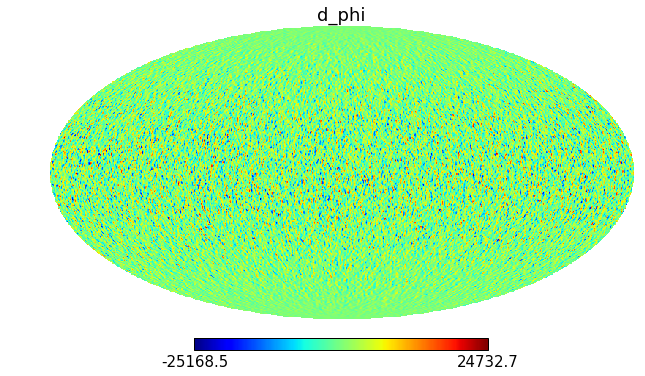

In [10]:
hp.mollview(d_theta, title='d_theta')
hp.mollview(d_phi,title='d_phi')

## second derivatives

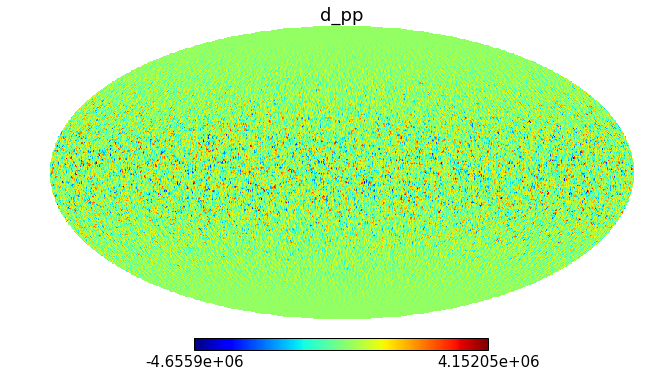

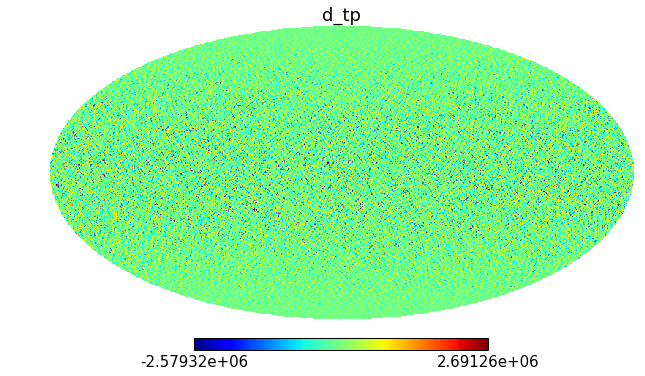

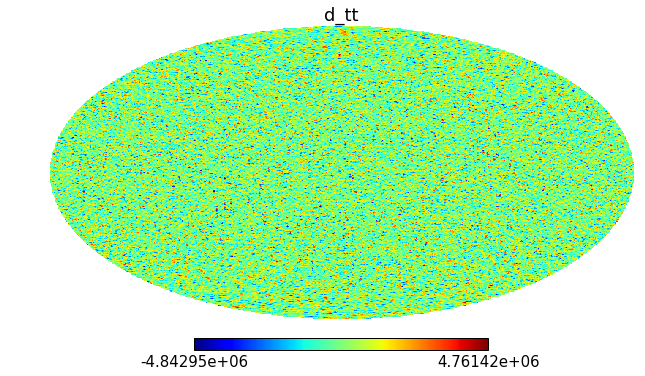

In [11]:
hp.mollview(dermap_pp, title='d_pp')
hp.mollview(dermap_tp,title='d_tp')
hp.mollview(dermap_tt,title='d_tt')

## verify that the derivative make sense
$
\begin{align}
\frac{\partial Y_{lm}}{\partial \phi} = im  Y_{lm}
\end{align}
$

$
\begin{align}
\frac{\partial Y_{lm}}{\partial \theta} = m \cot(\theta) Y_{lm} + \frac{\sqrt{\Gamma (l-m+1)} \sqrt{\Gamma(l+m+2)}}{\sqrt{\Gamma(l+m+1)}\Gamma(l-m)} e^{i \phi} Y_{l \; m+1}
\end{align}
$

Try to verify if the first relation is correct.

In [12]:
alm_t = hp.map2alm(d_phi)

In [13]:
Alm = hp.Alm()
lmax = Alm.getlmax(len(testalm[0]))
alm_t2 = np.array([1.j*alm*Alm.getlm(lmax,i)[1] for i, alm in enumerate(testalm[0])])

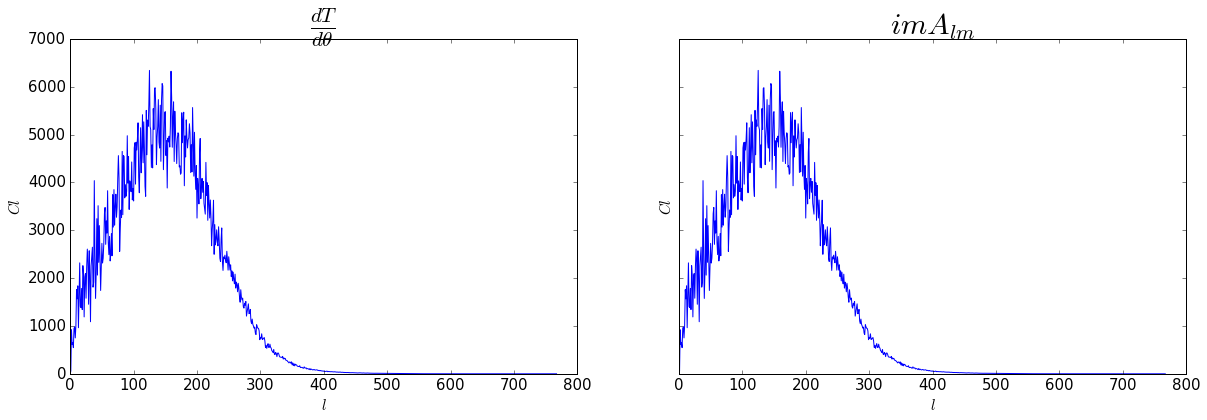

In [14]:
cl1 = hp.alm2cl(alm_t)
cl2 = hp.alm2cl(alm_t2)

f, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize = (20,6))
ax1.plot(cl1, label = 'dT_dtheta')
ax2.plot(cl2, label = 'm A_lm')
ax1.set_title(r'$\frac{d T}{d \theta}$', fontsize = 30)
ax2.set_title(r'$im A_{lm}$', fontsize = 30)
ax1.set_xlabel(r'$l$')
ax2.set_xlabel(r'$l$')
ax1.set_ylabel(r'$Cl$')
ax2.set_ylabel(r'$Cl$')

In [21]:
#plt.plot(cl1[1:]/cl2[1:])

## normalize deprojection maps
* Gain
* Pointing x
* Pointing y
* Beamwidth
* Ellipticity, +
* Ellipticity, x

% for Gain, arcmin for Pointing in x and y

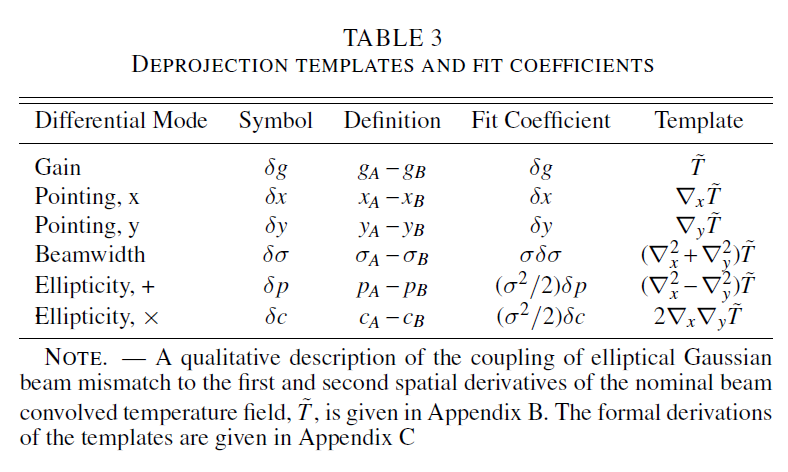

In [16]:
Image(filename='plots/deprojection_template_and_fit_coefficients.png',width = 500) 

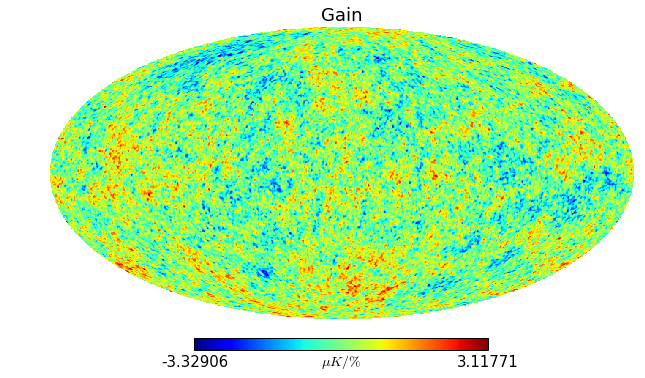

In [27]:
# Gain template 
T_normalized = 0.01*testmap[0]
hp.mollview(T_normalized, unit = r'$\mu K/\%$',title = 'Gain')

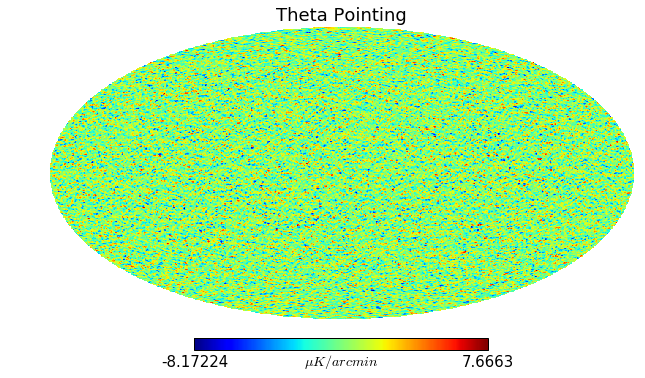

In [28]:
# Pointing theta
d_t_normalized = d_theta*np.pi /180./60.
hp.mollview(d_t_normalized, unit = r'$\mu K/arcmin$', title='Theta Pointing')

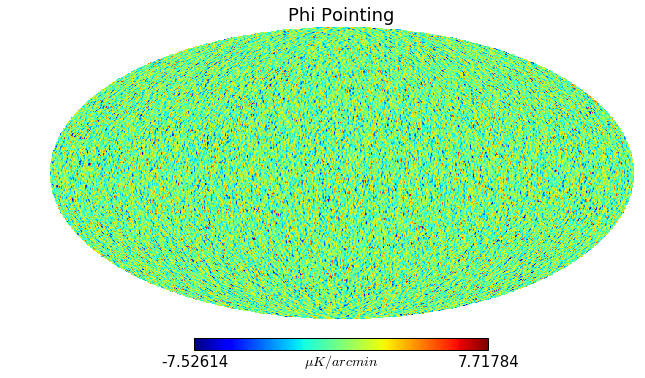

In [30]:
# Pointing phi
d_p_normalized = d_phi*np.pi /180./60. / sin_theta
hp.mollview(d_p_normalized, unit = r'$\mu K/arcmin$', title='Phi Pointing')

Beamwidth

$
\nabla^2 T = \frac{\partial^2}{\partial \theta^2}T
+ \frac{1}{\sin^2 \theta}\frac{\partial^2 T}{\partial \phi^2}
$



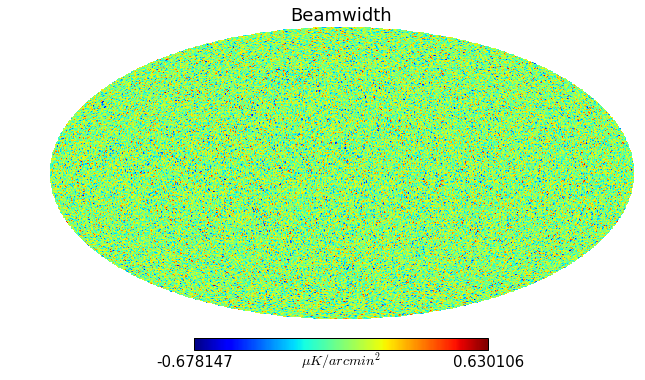

In [39]:
#$
#\nabla^2 T = \frac{1}{\sin \theta}\frac{\partial}{\partial \theta}(\sin \theta \frac{\partial T}{\partial \theta})
#+ \frac{1}{\sin^2 \theta}\frac{\partial^2 T}{\partial \phi^2}
#$
# Beamwidth
cos_theta = np.cos(hp.pix2ang(nside = nside, ipix = range(hp.nside2npix(nside)))[0])
const = np.pi /180./60.
#beamwidth_normalized = cos_theta/sin_theta*d_theta*const + dermap_tt*const**2 + dermap_pp/ sin_theta**2 * const**2
beamwidth_normalized =  dermap_tt*const**2 + dermap_pp/ sin_theta**2 * const**2
hp.mollview(beamwidth_normalized, unit = r'$\mu K / arcmin^2$', title = 'Beamwidth')